In [1]:
#Import Packages
import os
import pandas as pd
import numpy as np

#Change Working Directory
os.chdir(r'E:\DHICA\21009 - Quepos\90009_Damas')

#Read the Data
data = pd.read_csv('90009_Damas.csv')

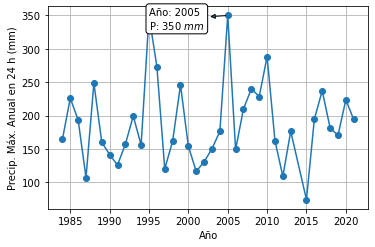

In [2]:
#Plot the Data
import matplotlib.pyplot as plt

#Maximum Values
id_max = data['PMax_24'].idxmax()
x_max = data['Year'].loc[id_max]
y_max = data['PMax_24'].loc[id_max]
label = 'Año: %d \nP: %d $mm$' % (x_max, y_max)

#Conversion
cm = 1/2.54

#Plot
fig, ax = plt.subplots(figsize=(13.5*cm, 9*cm), facecolor='white', tight_layout=True)

#Plot 1
ax.plot(data['Year'], data['PMax_24'], marker='o', color='tab:blue')
ax.set_xlabel('Año')
ax.set_ylabel('Precip. Máx. Anual en 24 h (mm)')
ax.annotate(text=label, xy=(x_max, y_max), xytext=(x_max-10, y_max-20), arrowprops={'arrowstyle':'<|-'},
             bbox={'boxstyle':'round', 'facecolor':'white', 'edgecolor':'black'}, annotation_clip=True)
ax.grid()

#Show Plots
plt.savefig('rainfall.png', dpi=300)
plt.show()

In [3]:
#Get Data
values = data['PMax_24'].values

#Fit GEV
from scipy.stats import genextreme

c_fit, loc_fit, scale_fit = genextreme.fit(values)

In [4]:
print(f"n = {len(values)}\nc = {c_fit}\nloc = {loc_fit}\nscale = {scale_fit}")

#Write Parameters
f = open('gev_parameters.txt','w')
f.write('n = ' + str(len(values)))
f.write('\nc = ' + str(c_fit))
f.write('\nloc = ' + str(loc_fit))
f.write('\nscale = ' + str(scale_fit))
f.close()

n = 37
c = 0.051939515742692205
loc = 160.63136695404427
scale = 51.09314578889572


In [5]:
#KS-Test
from scipy import stats
from scipy.stats import ksone
from scipy.stats import anderson

alpha = 0.05
ks, p = stats.ks_1samp(values, genextreme.cdf, args=(c_fit, loc_fit, scale_fit))
ks_crit = ksone.ppf(1-alpha/2, len(values))
print('KS: %f \nKS_Crit: %f' % (ks, ks_crit))
if ks < ks_crit:
    print('Good Fit!')
else:
    print('BAD Fit')

#Anderson-Darling Test
statistic, critical_values, significance = anderson(values, dist='gumbel')
print('\nAnderson statistic: %f' % (statistic))
print('Critical Anderson-Darling:', critical_values)
print('Anderson-Darling Significance Level:', significance)
if  statistic > critical_values[2]:
    print('Good Fit!')
else:
    print('BAD Fit')

KS: 0.069846 
KS_Crit: 0.218258
Good Fit!

Anderson statistic: 1.817687
Critical Anderson-Darling: [0.459 0.617 0.733 0.849 1.005]
Anderson-Darling Significance Level: [25.  10.   5.   2.5  1. ]
Good Fit!


In [6]:
#Estimate Design Rainfall Values
return_periods = [2, 5, 10, 25, 50, 100, 500]
pp_design = []

for i in return_periods:
    pp_design.append(np.round(genextreme.ppf(1 - 1/i, c=c_fit, loc=loc_fit, scale=scale_fit),2))

In [7]:
%%time
#Bootstraped Confidence Intervals
np.random.seed(0)

n_size = len(values)
alpha = 0.95
ks_crit = ksone.ppf(1-alpha/2, n_size)

x = np.linspace(np.min(values), np.max(values), 100)
return_periods = [2, 5, 10, 25, 50, 100, 500]
column_names = []

for i in return_periods:
    column = 'PP' + str(i)
    column_names.append(column)
    
PP = pd.DataFrame(columns=column_names)
CDF_DF = pd.DataFrame(columns=x)
PDF_DF = pd.DataFrame(columns=x)

iter = 300
i = 0
while i < iter:
    #Create Parametric Bootsrap Sample
    sample = []
    for j in range(n_size):
        sample.append(np.round(genextreme.ppf(np.random.random(1)[0], c=c_fit, loc=loc_fit, scale=scale_fit),2))
    
    #Fit Sample
    c_samp, loc_samp, scale_samp = genextreme.fit(sample)
    
    #GoF Test
    ks, p = stats.ks_1samp(sample, genextreme.cdf, args=(c_samp, loc_samp, scale_samp))
    if ks < ks_crit:
        for j in return_periods:
            PP.loc[i, ['PP' + str(j)]] = np.round(genextreme.ppf(1 - 1/j, c=c_samp, loc=loc_samp, scale=scale_samp),2)
        for j in x:
            CDF_DF.loc[i, [j]] = genextreme.cdf(j, c=c_samp, loc=loc_samp, scale=scale_samp)
            PDF_DF.loc[i, [j]] = genextreme.pdf(j, c=c_samp, loc=loc_samp, scale=scale_samp)
        i += 1
print('Fittings: ', str(len(PP)))

C:\anaconda3\envs\geo_py38\lib\site-packages\scipy\stats\_continuous_distns.py:2492: RuntimeWarning: invalid value encountered in subtract
  -pex2+logpex2-logex2)


Fittings:  300
Wall time: 2min 22s


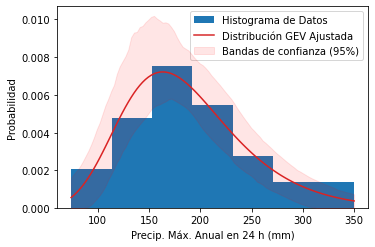

In [8]:
#95% Confidence Bands PDF
lower_bound, upper_bound = [], []

for i in x:
    lower_bound.append(np.round(PDF_DF[i].quantile(0.025),5))
    upper_bound.append(np.round(PDF_DF[i].quantile(0.975),5))
    
#Plot
fig, ax = plt.subplots(figsize=(13.5*cm, 9*cm), facecolor='white', tight_layout=True)

pdf_fit = genextreme.pdf(x, c=c_fit, loc=loc_fit, scale=scale_fit)

#Plot 1
ax.hist(values, bins=7, density=True, label='Histograma de Datos', zorder=0)
ax.plot(x, pdf_fit, marker='', color='tab:red', label='Distribución GEV Ajustada', zorder=5)
ax.fill_between(x, lower_bound, upper_bound, color='r', alpha=.1, label='Bandas de confianza (95%)', zorder=10)
ax.set_xlabel('Precip. Máx. Anual en 24 h (mm)')
ax.set_ylabel('Probabilidad')
handles, labels = ax.get_legend_handles_labels()
order = [1,0,2]
handles = [handles[i] for i in order]
labels = [labels[i] for i in order]
ax.legend(handles, labels)

#Show Plot
plt.savefig('pdf_95.png', dpi=300)
plt.show()

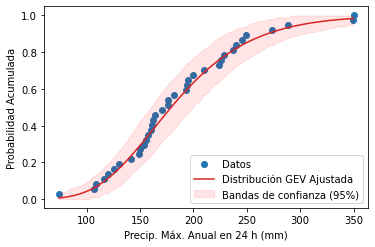

In [9]:
#95% Confidence Bands CDF
from scipy.stats.mstats import plotting_positions

lower_bound, upper_bound = [], []

for i in x:
    lower_bound.append(np.round(CDF_DF[i].quantile(0.025),2))
    upper_bound.append(np.round(CDF_DF[i].quantile(0.975),2))
    
#Plot
fig, ax = plt.subplots(figsize=(13.5*cm, 9*cm), facecolor='white', tight_layout=True)

cdf_values = plotting_positions(values, alpha=0, beta=1)
cdf_fit = genextreme.cdf(x, c=c_fit, loc=loc_fit, scale=scale_fit)

#Plot 2
ax.scatter(values, cdf_values, marker='o', label='Datos', zorder=0)
ax.plot(x, cdf_fit, marker='', color='tab:red', label='Distribución GEV Ajustada', zorder=5)
ax.fill_between(x, lower_bound, upper_bound, color='r', alpha=.1, label='Bandas de confianza (95%)', zorder=10)
#ax.set_xticks(np.arange(0, 500, step=10))
#ax.set_xlim(0,101.2)
#ax.set_ylim(150,550)
ax.set_xlabel('Precip. Máx. Anual en 24 h (mm)')
ax.set_ylabel('Probabilidad Acumulada')
handles, labels = ax.get_legend_handles_labels()
order = [1,0,2]
handles = [handles[i] for i in order]
labels = [labels[i] for i in order]
ax.legend(handles, labels)

#Show Plot
plt.savefig('cdf_95.png', dpi=300)
plt.show()

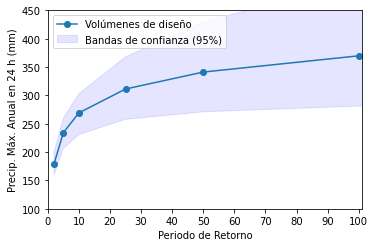

In [10]:
#95% Confidence Bands
lower_bound, upper_bound = [], []

for i in column_names:
    lower_bound.append(np.round(PP[i].quantile(0.025),2))
    upper_bound.append(np.round(PP[i].quantile(0.975),2))

#Plot
fig, ax = plt.subplots(figsize=(13.5*cm, 9*cm), facecolor='white', tight_layout=True)

#Plot 1
ax.plot(return_periods, pp_design, marker='o', label='Volúmenes de diseño')
ax.fill_between(return_periods, lower_bound, upper_bound, color='b', alpha=.1, label='Bandas de confianza (95%)')
ax.set_xticks(np.arange(0, 500, step=10))
ax.set_xlim(0,101.2)
ax.set_ylim(100,450)
ax.set_xlabel('Periodo de Retorno')
ax.set_ylabel('Precip. Máx. Anual en 24 h (mm)')
ax.legend(loc=2)

#Show Plot
plt.savefig('confidence.png', dpi=300)
plt.show()

In [11]:
#Save Results
df = pd.DataFrame(list(zip(return_periods, pp_design, lower_bound, upper_bound)),
               columns =['Return Period', 'PP', 'Lower Bound', 'Upper Bound'])
df.to_csv('results.csv')

In [13]:
#Evento Particular
evento = 250 #mm
cdf_evento = genextreme.cdf(evento, c=c_fit, loc=loc_fit, scale=scale_fit)
print('Periodo de retorno del evento:', str(np.round(1/(1 - cdf_evento), 2)), 'años')

Periodo de retorno del evento: 6.77 años
